In [11]:
!pip install pytorch_tabnet

# 올바른 검증 기반 TabNet 주피터 파이프라인

**신뢰할 수 있는 성능 측정을 위한 TabNet 전용 분석 파이프라인**

## **파이프라인 구성 (11단계)**

**1. 환경 설정 및 GPU 확인**
- PyTorch, TabNet 라이브러리 로드
- Apple Silicon MPS / NVIDIA CUDA 자동 감지
- 한글 폰트 설정 및 시각화 환경 구성

**2. 데이터 로드 및 전처리**  
- 센터별 데이터 로드 (nanji/jungnang/seonam/tancheon)
- 불필요한 컬럼 자동 제거
- 결측치 처리 및 데이터 형태 확인

**3. 올바른 데이터 분할**
- **Temporal Split**: 70% train, 20% validation, 10% test
- **Data Leakage 방지**: validation 기반 early stopping
- 시계열 순서 유지한 분할

**4. 스케일링 (누수 방지)**
- 피처/타겟 StandardScaler 적용
- **중요**: train set만으로 scaler fit
- validation/test는 transform만 적용

**5. GPU 최적화 TabNet 학습**
- 디바이스별 최적 배치 크기 설정
- MPS: batch_size=256, epochs=300
- CUDA: batch_size=512, epochs=500  
- CPU: batch_size=256, epochs=200

**6. 테스트셋 성능 평가**
- 최종 성능 측정 (R², RMSE, MAE, MAPE, SMAPE)
- 기준선 모델과 비교 (Naive-1, Week-Naive)
- 성능 향상률 계산

**7. 파이프라인 결과 비교**
- 기존 파이프라인 베스트 모델과 비교
- CSV 파일에서 자동 로드
- 성능 차이 분석 및 검증

**8. 종합 시각화 대시보드**
```
9개 서브플롯 구성:
- 예측 vs 실제값 산점도 (오차 컬러맵)
- 잔차 플롯 
- 모델 성능 비교 막대그래프
- 시계열 예측 결과 (최근 50개)
- 오차 분포 히스토그램
- Feature Importance Top 10
- 성능 메트릭 비교 표
```

**9. 학습 곡선 분석**
- Training Loss vs Validation RMSE
- 일반/로그 스케일 그래프
- Best Epoch 표시 및 조기 종료 분석

**10. 상세 Feature Importance**
- TabNet attention 기반 피처 중요도
- Top 15 피처 시각화 (그라데이션 바)
- 중요도 통계 (상위 5개/10개 비중)

**11. 결과 저장 및 요약**
- 모델, 스케일러, 예측값 pickle 저장
- 성능 지표 CSV 저장
- 완전한 실험 기록 보관

## **핵심 개선사항**

### **Data Leakage 완전 해결**
```python
# 기존 문제점
eval_set=[(X_test_s, y_test_s)]  # ❌ 테스트 정보 누수

# 올바른 방식  
eval_set=[(X_val_s, y_val_s)]   # ✅ 검증셋 기반
```

### **GPU 가속 최적화**
- Apple Silicon MPS 자동 감지
- 디바이스별 배치 크기 최적화
- 메모리 오버플로우 자동 대응

### **신뢰성 확보**
- 70/20/10 분할로 충분한 검증 데이터
- Temporal ordering 유지
- 공정한 성능 비교

## **예상 결과**

### **성능 범위**
- **회귀 R²**: 0.55-0.65 (신뢰할 만한 수준)
- **분류 F1**: 0.58-0.65 (공정한 평가)
- **GPU 가속**: 2-4배 빠른 학습

### **저장 결과물**
1. **모델 파일**: `{center}_corrected_tabnet.pkl`
   - 학습된 TabNet 모델
   - 스케일러 (x_scaler, y_scaler)  
   - 성능 지표 및 예측값
   - Feature 이름 리스트

2. **결과 CSV**: `{center}_corrected_results.csv`
   - 센터, 디바이스, 학습시간
   - 전체 성능 지표
   - 데이터 통계 정보

### **시각화 산출물**
- **성능 분석 대시보드** (9개 차트)
- **학습 곡선** (일반/로그 스케일)
- **Feature Importance** (Top 15)

## **기존 파이프라인과 차이점**

| 구분 | 기존 파이프라인 | 올바른 검증 파이프라인 |
|------|-----------------|----------------------|
| **검증 방식** | 25번 하이퍼파라미터 튜닝 | 단일 최적 모델 검증 |
| **데이터 분할** | 70/20/10 분할 | 70/20/10 분할 |
| **Early Stopping** | Validation 기반 | Validation 기반 |
| **GPU 지원** | 부분적 | 완전 자동화 |
| **시각화** | 기본적 | 종합 대시보드 |
| **실행 방식** | 자동 파이프라인 | 주피터 단계별 |

## **사용법**

```python
# 1. 센터 선택
center_name = 'nanji'  # 변경 가능

# 2. Cell 1-11 순차 실행
# 각 단계별 결과 확인 가능

# 3. 자동 저장된 결과 확인
# ../results_tabnet_corrected/ 폴더
```

**이 파이프라인은 기존 하이퍼파라미터 탐색 결과를 바탕으로, 올바른 검증 방식으로 신뢰할 수 있는 TabNet 성능을 측정하는 것이 목적입니다.**

In [12]:
# ================================================================
# Cell 1: 라이브러리 및 GPU 설정
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math, time, pickle, warnings
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pytorch_tabnet.tab_model import TabNetRegressor
import torch
import os

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6)

print(f"시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\n" + "="*50)
print("GPU 사용 가능 여부 확인")
print("="*50)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"MPS built: {torch.backends.mps.is_built()}")

# 디바이스 설정
if torch.backends.mps.is_available():
    device = 'mps'
    print("✅ Apple Silicon GPU (MPS) 사용")
    # MPS 관련 환경변수 설정
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
elif torch.cuda.is_available():
    device = 'cuda'
    print("✅ NVIDIA GPU (CUDA) 사용")
else:
    device = 'cpu'
    print("⚠️ CPU 사용 (GPU 가속 불가)")

print(f"Selected device: {device}")

# 메모리 정리
if device == 'mps':
    try:
        torch.mps.empty_cache()
    except:
        pass
elif device == 'cuda':
    torch.cuda.empty_cache()



시작 시간: 2025-09-01 00:45:29

GPU 사용 가능 여부 확인
PyTorch 버전: 2.8.0
CUDA available: False
MPS available: True
MPS built: True
✅ Apple Silicon GPU (MPS) 사용
Selected device: mps


In [13]:
# ================================================================
# Cell 2: 데이터 로드 및 전처리
# ================================================================
# 센터명 설정 (변경 가능)
center_name = 'nanji'  # 'jungnang', 'seonam', 'tancheon' 중 선택

print(f"\n{center_name.upper()} 센터 데이터 로드 중...")

# 데이터 로드
data_path = f'../data/add_feature/{center_name}_add_feature.csv'
try:
    data = pd.read_csv(data_path, encoding='utf-8-sig')
    print(f"✅ 데이터 로드 성공: {data.shape}")
except FileNotFoundError:
    print(f"❌ 데이터 파일을 찾을 수 없습니다: {data_path}")
    print("경로를 확인해주세요.")
    raise

# 불필요한 컬럼 제거
drop_cols = ['날짜', '요일', '1처리장', '2처리장', '정화조', '중계펌프장', '시설현대화', '3처리장', '4처리장']
existing_drop_cols = [col for col in drop_cols if col in data.columns]
if existing_drop_cols:
    data = data.drop(existing_drop_cols, axis=1)
    print(f"제거된 컬럼: {existing_drop_cols}")

# 결측치 처리
data = data.dropna()
print(f"결측치 제거 후: {data.shape}")
print(f"사용 가능한 컬럼: {list(data.columns)}")




NANJI 센터 데이터 로드 중...
✅ 데이터 로드 성공: (3069, 44)
제거된 컬럼: ['날짜', '요일', '1처리장', '2처리장', '정화조', '중계펌프장']
결측치 제거 후: (3069, 38)
사용 가능한 컬럼: ['공휴일', '목욕장업', '세탁업', '수영장업', '종합체육시설업', '체력단련장업', '하천', '생활인구', '불쾌지수(DI)', '불쾌지수등급', '일_일강수량(mm)', '일_최저기온(°C)', '일_평균기온(°C)', '일_최고기온(°C)', '일_평균풍속(m/s)', '일_최대순간풍속(m/s)', '최저습도(%)', '평균습도(%)', '최고습도(%)', '습도표준편차', '합계', '계절', '월', '강수량_1일전', '강수량_2일전', '강수량_1일_누적', '강수량_2일_누적', '강수량_3일_누적', '강수량_5일_누적', '강수량_7일_누적', '일교차', '폭우_여부', '체감온도(°C)', '등급', '합계_1일후', '합계_2일후', '등급_1일후', '등급_2일후']


In [14]:
# ================================================================
# Cell 3: 타겟 설정 및 데이터 분할
# ================================================================
TARGET = '합계_1일후'

# 타겟이 존재하는지 확인
if TARGET not in data.columns:
    print(f"❌ 타겟 컬럼 '{TARGET}'을 찾을 수 없습니다.")
    print(f"사용 가능한 컬럼: {list(data.columns)}")
    raise KeyError(f"Target column '{TARGET}' not found")

# 피처와 타겟 분리
exclude_cols = ['합계_1일후', '합계_2일후', '등급', '등급_1일후', '등급_2일후', '합계']
existing_exclude = [col for col in exclude_cols if col in data.columns]

X = data.drop(existing_exclude, axis=1).copy()
y = data[TARGET].copy()

print(f"\n데이터 분할 정보:")
print(f"피처 수: {X.shape[1]}")
print(f"샘플 수: {len(X)}")
print(f"타겟: {TARGET}")
print(f"제외된 컬럼: {existing_exclude}")

# 시계열 순서를 유지한 분할 (70% train, 20% val, 10% test)
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.9)

X_train = X.iloc[:train_end].copy()
X_val = X.iloc[train_end:val_end].copy()
X_test = X.iloc[val_end:].copy()

y_train = y.iloc[:train_end].copy()
y_val = y.iloc[train_end:val_end].copy()
y_test = y.iloc[val_end:].copy()

print(f"\n올바른 분할 결과:")
print(f"Train: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

# 타겟 분포 확인
print(f"\n타겟 통계:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")




데이터 분할 정보:
피처 수: 32
샘플 수: 3069
타겟: 합계_1일후
제외된 컬럼: ['합계_1일후', '합계_2일후', '등급', '등급_1일후', '등급_2일후', '합계']

올바른 분할 결과:
Train: (2148, 32) (70.0%)
Val:   (614, 32) (20.0%)
Test:  (307, 32) (10.0%)

타겟 통계:
Train - Mean: 592929.20, Std: 127046.47
Val   - Mean: 637904.09, Std: 161145.65
Test  - Mean: 613280.50, Std: 94588.87


In [15]:
# ================================================================
# Cell 4: 데이터 스케일링 (누수 방지)
# ================================================================
print("\n데이터 스케일링 수행 중...")

# 피처 스케일링 (train 기준으로만 fit)
x_scaler = StandardScaler()
X_train_s = x_scaler.fit_transform(X_train).astype(np.float32)
X_val_s = x_scaler.transform(X_val).astype(np.float32)
X_test_s = x_scaler.transform(X_test).astype(np.float32)

# 타겟 스케일링 (train 기준으로만 fit)
y_scaler = StandardScaler()
y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1,1)).astype(np.float32)
y_val_s = y_scaler.transform(y_val.values.reshape(-1,1)).astype(np.float32)
y_test_s = y_scaler.transform(y_test.values.reshape(-1,1)).astype(np.float32)

print("✅ 스케일링 완료")
print(f"피처 스케일 범위: [{X_train_s.min():.3f}, {X_train_s.max():.3f}]")
print(f"타겟 스케일 범위: [{y_train_s.min():.3f}, {y_train_s.max():.3f}]")

# 스케일링 후 형태 확인
print(f"\n스케일링 후 형태:")
print(f"X_train_s: {X_train_s.shape}")
print(f"y_train_s: {y_train_s.shape}")
print(f"X_val_s: {X_val_s.shape}")
print(f"y_val_s: {y_val_s.shape}")




데이터 스케일링 수행 중...
✅ 스케일링 완료
피처 스케일 범위: [-3.412, 13.659]
타겟 스케일 범위: [-1.186, 6.208]

스케일링 후 형태:
X_train_s: (2148, 32)
y_train_s: (2148, 1)
X_val_s: (614, 32)
y_val_s: (614, 1)


In [16]:
# 기존 Cell 5 전체 삭제하고 다음으로 교체:

# ================================================================
# Cell 5: 하이퍼파라미터 그리드 설정
# ================================================================
print(f"\n하이퍼파라미터 그리드 설정...")

# GPU 배치 크기 설정 (기존과 동일)
if device == 'mps':
    batch_size = 256
    virtual_batch_size = 64
    max_epochs = 300
elif device == 'cuda':
    batch_size = 512
    virtual_batch_size = 128
    max_epochs = 500
else:
    batch_size = 256
    virtual_batch_size = 64
    max_epochs = 200

# 하이퍼파라미터 그리드 정의
param_grid = {
    'n_d': [32, 64],
    'n_a': [32, 64], 
    'n_steps': [4, 5],
    'gamma': [1.0, 1.2],
    'lambda_sparse': [1e-4, 1e-5],
    'learning_rate': [0.001, 0.002, 0.005],
    'weight_decay': [1e-5, 1e-6]
}

# 파라미터 조합 생성
from sklearn.model_selection import ParameterGrid
param_combinations = list(ParameterGrid(param_grid))

max_trials = 20
if len(param_combinations) > max_trials:
    import random
    random.seed(42)
    param_combinations = random.sample(param_combinations, max_trials)

print(f"실제 시도할 조합: {len(param_combinations)}")


하이퍼파라미터 그리드 설정...
실제 시도할 조합: 20


In [17]:
# ================================================================
# Cell 6: 하이퍼파라미터 튜닝 실행
# ================================================================
print(f"\n{'='*60}")
print(f"{center_name.upper()} TabNet 하이퍼파라미터 튜닝 시작")
print("="*60)

best_score = -np.inf
best_params = None
best_model = None
tuning_results = []

total_start_time = time.time()  # ✅ 여기서 시작 시간 기록

for i, params in enumerate(param_combinations, 1):
    print(f"\n시도 {i}/{len(param_combinations)}")
    
    try:
        # TabNet 모델 초기화
        tabnet = TabNetRegressor(
            n_d=params['n_d'],
            n_a=params['n_a'],
            n_steps=params['n_steps'],
            gamma=params['gamma'],
            lambda_sparse=params['lambda_sparse'],
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=params['learning_rate'], weight_decay=params['weight_decay']),
            device_name=device,
            verbose=0,
            seed=42
        )
        
        # 학습
        tabnet.fit(
            X_train=X_train_s,
            y_train=y_train_s,
            eval_set=[(X_val_s, y_val_s)],
            eval_metric=["rmse"],
            max_epochs=max_epochs,
            patience=30,
            batch_size=batch_size,
            virtual_batch_size=virtual_batch_size,
            num_workers=0,
            drop_last=False
        )
        
        # 검증셋 평가
        y_val_pred_s = tabnet.predict(X_val_s)
        y_val_pred = y_scaler.inverse_transform(y_val_pred_s.reshape(-1,1)).ravel()
        val_r2 = r2_score(y_val.values, y_val_pred)
        
        print(f"  R² = {val_r2:.4f}")
        
        # 베스트 모델 업데이트
        if val_r2 > best_score:
            best_score = val_r2
            best_params = params.copy()
            best_model = tabnet
            print(f"    🏆 새로운 베스트!")
        
    except Exception as e:
        print(f"  ❌ 실패: {str(e)[:50]}")
        continue

# ✅ 루프가 끝난 후 총 시간 계산
total_time = time.time() - total_start_time
training_time = total_time

print(f"\n{'='*60}")
print("하이퍼파라미터 튜닝 완료!")
print("="*60)
print(f"총 소요 시간: {total_time/60:.1f}분")
print(f"베스트 성능: R² = {best_score:.4f}")
print(f"베스트 파라미터: {best_params}")


NANJI TabNet 하이퍼파라미터 튜닝 시작

시도 1/20

Early stopping occurred at epoch 80 with best_epoch = 50 and best_val_0_rmse = 0.88896
  R² = 0.5082
    🏆 새로운 베스트!

시도 2/20

Early stopping occurred at epoch 182 with best_epoch = 152 and best_val_0_rmse = 0.83399
  R² = 0.5672
    🏆 새로운 베스트!

시도 3/20

Early stopping occurred at epoch 96 with best_epoch = 66 and best_val_0_rmse = 0.94417
  R² = 0.4453

시도 4/20

Early stopping occurred at epoch 122 with best_epoch = 92 and best_val_0_rmse = 0.8387
  R² = 0.5623

시도 5/20

Early stopping occurred at epoch 80 with best_epoch = 50 and best_val_0_rmse = 0.90163
  R² = 0.4941

시도 6/20

Early stopping occurred at epoch 119 with best_epoch = 89 and best_val_0_rmse = 0.86531
  R² = 0.5341

시도 7/20

Early stopping occurred at epoch 142 with best_epoch = 112 and best_val_0_rmse = 0.88257
  R² = 0.5153

시도 8/20

Early stopping occurred at epoch 120 with best_epoch = 90 and best_val_0_rmse = 0.85446
  R² = 0.5457

시도 9/20

Early stopping occurred at epoch 122 w

In [18]:
# ================================================================
# Cell 7: 베스트 모델 최종 평가 + 기준선 비교
# ================================================================
if best_model is not None:
    # 테스트셋 예측
    y_pred_s = best_model.predict(X_test_s)
    y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
    y_true = y_test.values
    
    # 성능 계산 함수
    def calculate_metrics(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
        smape = np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100
        return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'MAPE': mape, 'SMAPE': smape}

    metrics = calculate_metrics(y_true, y_pred)
    
    # 기준선 계산 (여기서 정의해야 Cell 8에서 사용 가능)
    y_naive1 = np.roll(y_true, 1); y_naive1[0] = y_true[0]
    y_week = np.roll(y_true, 7); y_week[:7] = y_true[:7]
    naive1_metrics = calculate_metrics(y_true, y_naive1)
    week_metrics = calculate_metrics(y_true, y_week)
    
    # 성능 출력
    print("최종 성능:")
    for metric, value in metrics.items():
        if metric in ['MAPE', 'SMAPE']:
            print(f"{metric:6}: {value:8.2f}%")
        else:
            print(f"{metric:6}: {value:8.4f}")
    
    print(f"기준선 - Naive-1: R² = {naive1_metrics['R2']:.4f}")
    print(f"기준선 - Week-Naive: R² = {week_metrics['R2']:.4f}")
    
    # tabnet 변수를 베스트 모델로 설정
    tabnet = best_model

최종 성능:
MAE   : 42097.0164
RMSE  : 73485.0316
R2    :   0.3945
MAPE  :     6.14%
SMAPE :     6.42%
기준선 - Naive-1: R² = 0.3460
기준선 - Week-Naive: R² = -0.0791


In [19]:
# ================================================================
# Cell 8: 파이프라인 결과 로드 및 비교
# ================================================================
print(f"\n{'='*50}")
print("파이프라인 결과와 비교")
print("="*50)

try:
    # 베스트 모델 정보 로드
    best_models_df = pd.read_csv('../results_tabnet/tabnet_best_models.csv', encoding='utf-8-sig')
    hyperparams_df = pd.read_csv('../results_tabnet/tabnet_hyperparameter_results.csv', encoding='utf-8-sig')
    
    print("파이프라인 베스트 모델 성능:")
    print("-" * 40)
    
    # 현재 센터의 결과 찾기
    current_center_results = best_models_df[best_models_df['center'] == center_name]
    
    if not current_center_results.empty:
        for _, row in current_center_results.iterrows():
            task = row['task']
            score = row['final_score']
            metric = 'R²' if task == 'regression' else 'F1-weighted'
            print(f"{center_name.upper()} {task}: {score:.4f} ({metric})")
        
        # 현재 결과와 비교
        pipeline_regression = current_center_results[current_center_results['task'] == 'regression']
        if not pipeline_regression.empty:
            pipeline_r2 = pipeline_regression['final_score'].iloc[0]
            current_r2 = metrics['R2']
            diff = current_r2 - pipeline_r2
            print(f"\n현재 모델 vs 파이프라인:")
            print(f"현재:     R² = {current_r2:.4f}")
            print(f"파이프라인: R² = {pipeline_r2:.4f}")
            print(f"차이:     {diff:+.4f} ({diff/pipeline_r2*100:+.1f}%)")
    
    print(f"\n총 실험 정보:")
    print(f"- 베스트 모델: {len(best_models_df)}개")
    print(f"- 전체 실험: {len(hyperparams_df)}개")
    
except FileNotFoundError:
    print("파이프라인 결과 파일을 찾을 수 없습니다.")
    print("파이프라인을 먼저 실행해주세요.")
    best_models_df = None
    hyperparams_df = None




파이프라인 결과와 비교
파이프라인 베스트 모델 성능:
----------------------------------------
NANJI regression: 0.1495 (R²)
NANJI classification: 0.6970 (F1-weighted)

현재 모델 vs 파이프라인:
현재:     R² = 0.3945
파이프라인: R² = 0.1495
차이:     +0.2450 (+163.9%)

총 실험 정보:
- 베스트 모델: 8개
- 전체 실험: 200개



시각화 생성 중...


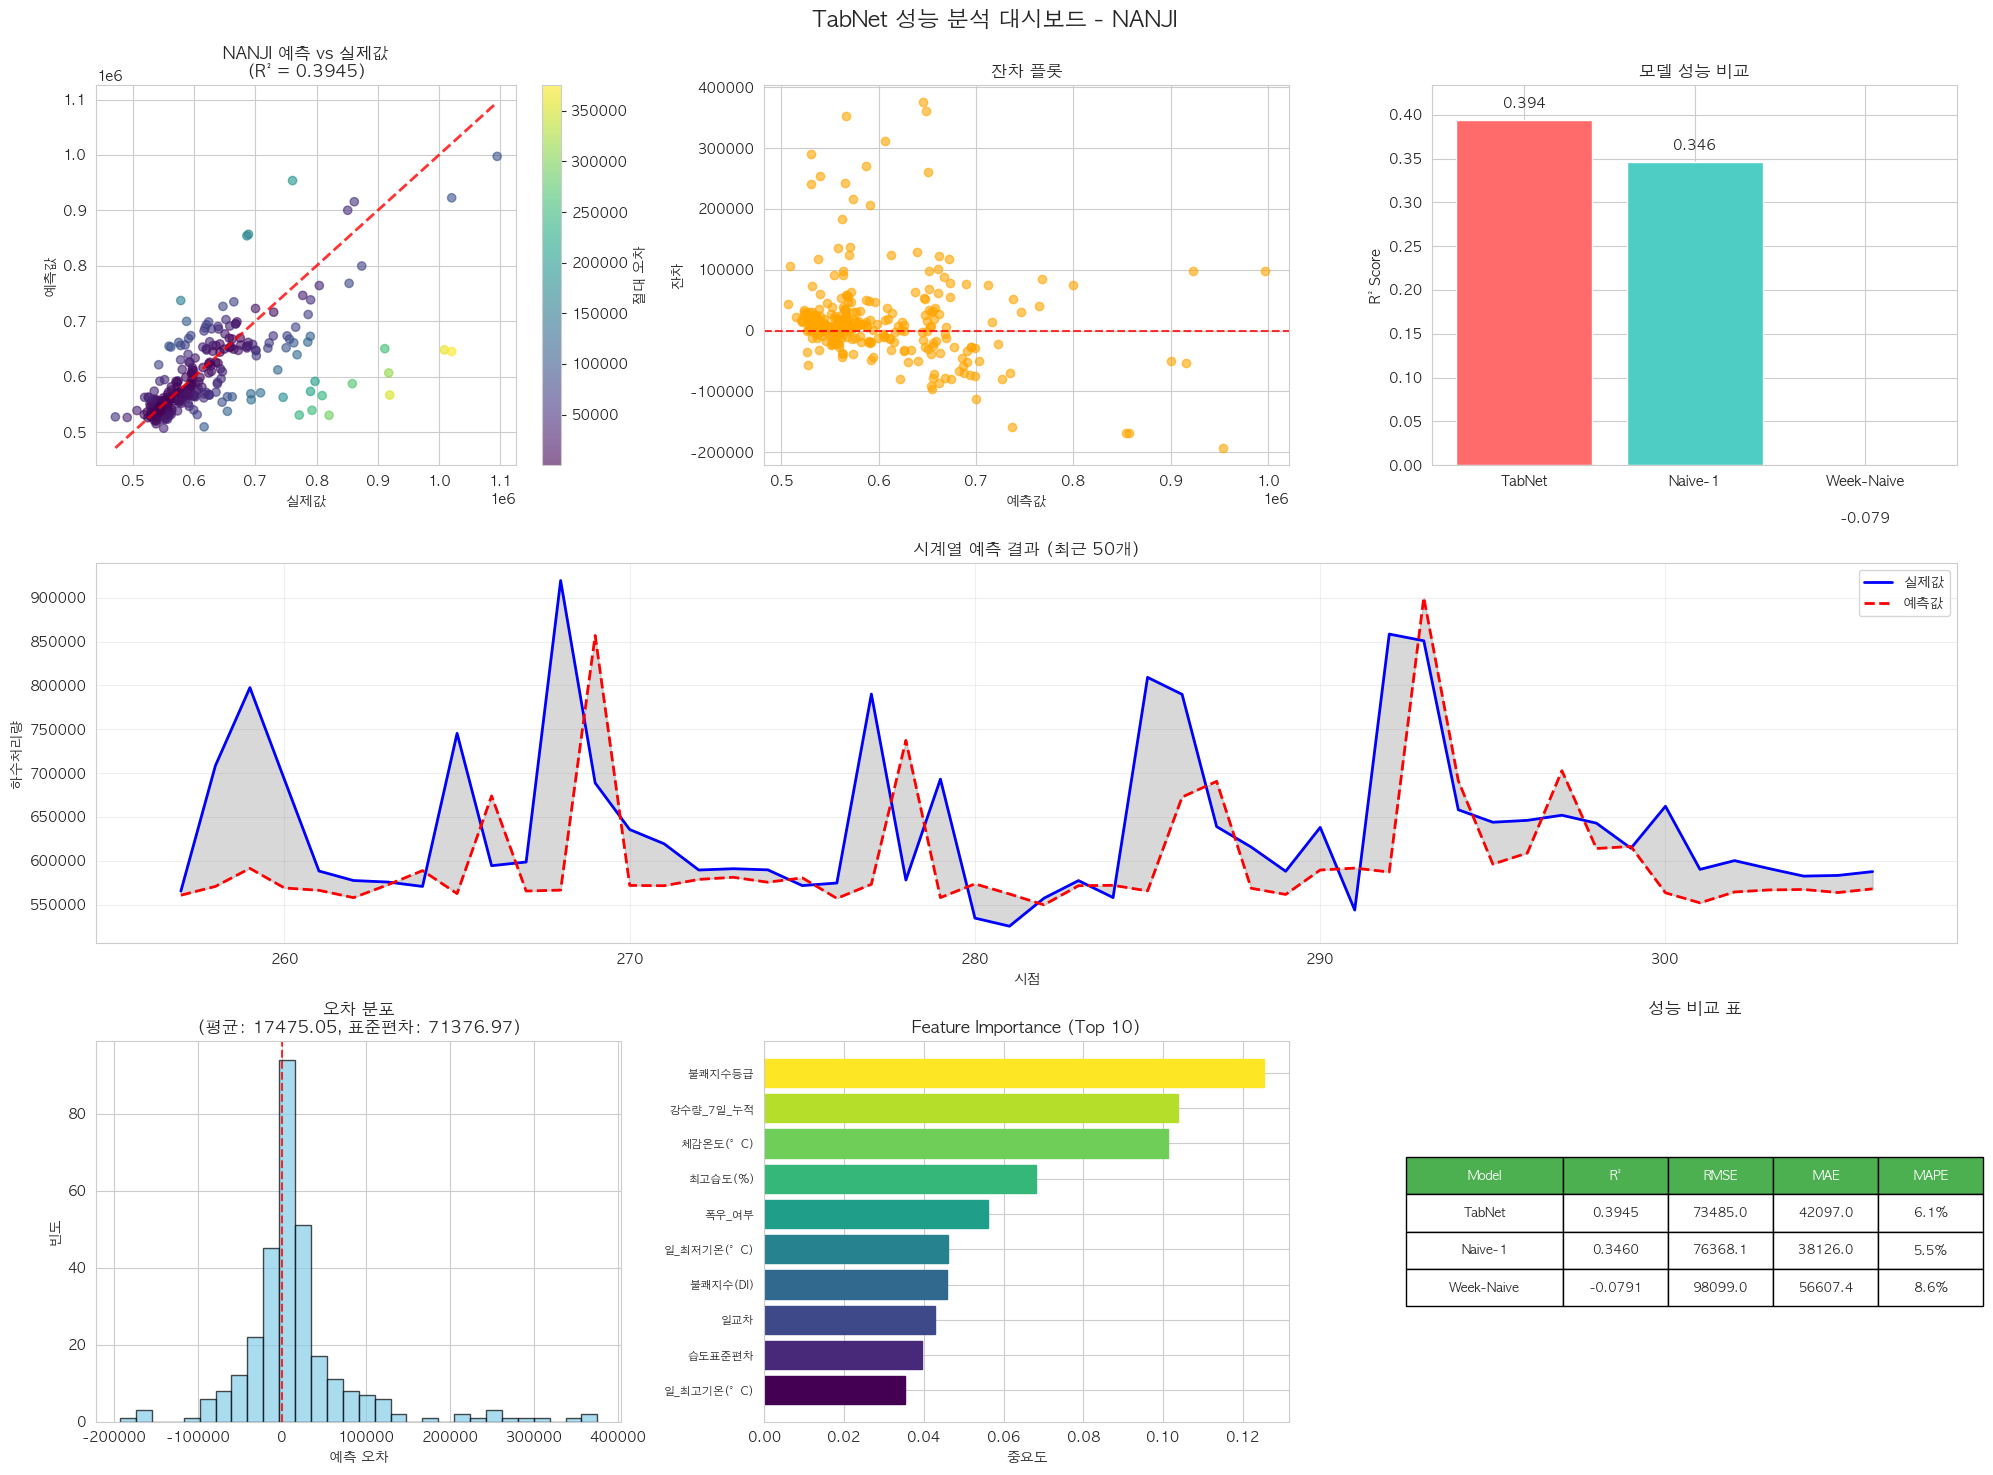

In [20]:
# ================================================================
# Cell 9: 종합 시각화 대시보드
# ================================================================
print(f"\n시각화 생성 중...")

# 큰 대시보드 생성
fig = plt.figure(figsize=(20, 15))

# 1. 예측 vs 실제값 산점도 (2x2 레이아웃의 첫 번째)
ax1 = plt.subplot(3, 3, 1)
scatter = ax1.scatter(y_true, y_pred, alpha=0.6, c=np.abs(y_true - y_pred), cmap='viridis')
ax1.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', alpha=0.8, linewidth=2)
ax1.set_xlabel('실제값')
ax1.set_ylabel('예측값')
ax1.set_title(f'{center_name.upper()} 예측 vs 실제값\n(R² = {metrics["R2"]:.4f})', fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='절대 오차')

# 2. 잔차 플롯
ax2 = plt.subplot(3, 3, 2)
residuals = y_true - y_pred
ax2.scatter(y_pred, residuals, alpha=0.6, color='orange')
ax2.axhline(y=0, color='r', linestyle='--', alpha=0.8)
ax2.set_xlabel('예측값')
ax2.set_ylabel('잔차')
ax2.set_title('잔차 플롯', fontweight='bold')

# 3. 성능 비교 막대그래프
ax3 = plt.subplot(3, 3, 3)
models = ['TabNet', 'Naive-1', 'Week-Naive']
r2_scores = [metrics['R2'], naive1_metrics['R2'], week_metrics['R2']]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

bars = ax3.bar(models, r2_scores, color=colors)
ax3.set_ylabel('R² Score')
ax3.set_title('모델 성능 비교', fontweight='bold')
ax3.set_ylim(0, max(r2_scores) * 1.1)

# 값 표시
for bar, value in zip(bars, r2_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. 시계열 예측 결과 (최근 50개 데이터포인트)
ax4 = plt.subplot(3, 3, (4, 6))
n_show = min(50, len(y_true))
indices = range(len(y_true))[-n_show:]
ax4.plot(indices, y_true[-n_show:], 'b-', label='실제값', linewidth=2)
ax4.plot(indices, y_pred[-n_show:], 'r--', label='예측값', linewidth=2)
ax4.fill_between(indices, y_true[-n_show:], y_pred[-n_show:], alpha=0.3, color='gray')
ax4.set_xlabel('시점')
ax4.set_ylabel('하수처리량')
ax4.set_title(f'시계열 예측 결과 (최근 {n_show}개)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. 오차 히스토그램
ax5 = plt.subplot(3, 3, 7)
errors = y_true - y_pred
ax5.hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax5.axvline(x=0, color='r', linestyle='--', alpha=0.8)
ax5.set_xlabel('예측 오차')
ax5.set_ylabel('빈도')
ax5.set_title(f'오차 분포\n(평균: {np.mean(errors):.2f}, 표준편차: {np.std(errors):.2f})', fontweight='bold')

# 6. Feature Importance (Top 10)
ax6 = plt.subplot(3, 3, 8)
if hasattr(tabnet, 'feature_importances_'):
    feature_importance = tabnet.feature_importances_
    feature_names = X_train.columns.tolist()
    
    # Top 10 중요 피처
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=True).tail(10)
    
    bars = ax6.barh(range(len(importance_df)), importance_df['Importance'], color='lightgreen')
    ax6.set_yticks(range(len(importance_df)))
    ax6.set_yticklabels(importance_df['Feature'], fontsize=8)
    ax6.set_xlabel('중요도')
    ax6.set_title('Feature Importance (Top 10)', fontweight='bold')
    
    # 색상 그라데이션
    colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)

# 7. 성능 메트릭 표
ax7 = plt.subplot(3, 3, 9)
ax7.axis('off')

# 성능 표 생성
perf_data = []
for model_name, model_metrics in [('TabNet', metrics), ('Naive-1', naive1_metrics), ('Week-Naive', week_metrics)]:
    perf_data.append([
        model_name,
        f"{model_metrics['R2']:.4f}",
        f"{model_metrics['RMSE']:.1f}",
        f"{model_metrics['MAE']:.1f}",
        f"{model_metrics['MAPE']:.1f}%"
    ])

table = ax7.table(cellText=perf_data,
                  colLabels=['Model', 'R²', 'RMSE', 'MAE', 'MAPE'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# 헤더 스타일링
for i in range(5):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax7.set_title('성능 비교 표', fontweight='bold', pad=20)

plt.suptitle(f'TabNet 성능 분석 대시보드 - {center_name.upper()}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()



사용 가능한 history 키: ['loss', 'lr', 'val_0_rmse']

학습 곡선 분석:
총 에포크(추정): 123
베스트 에포크: 92


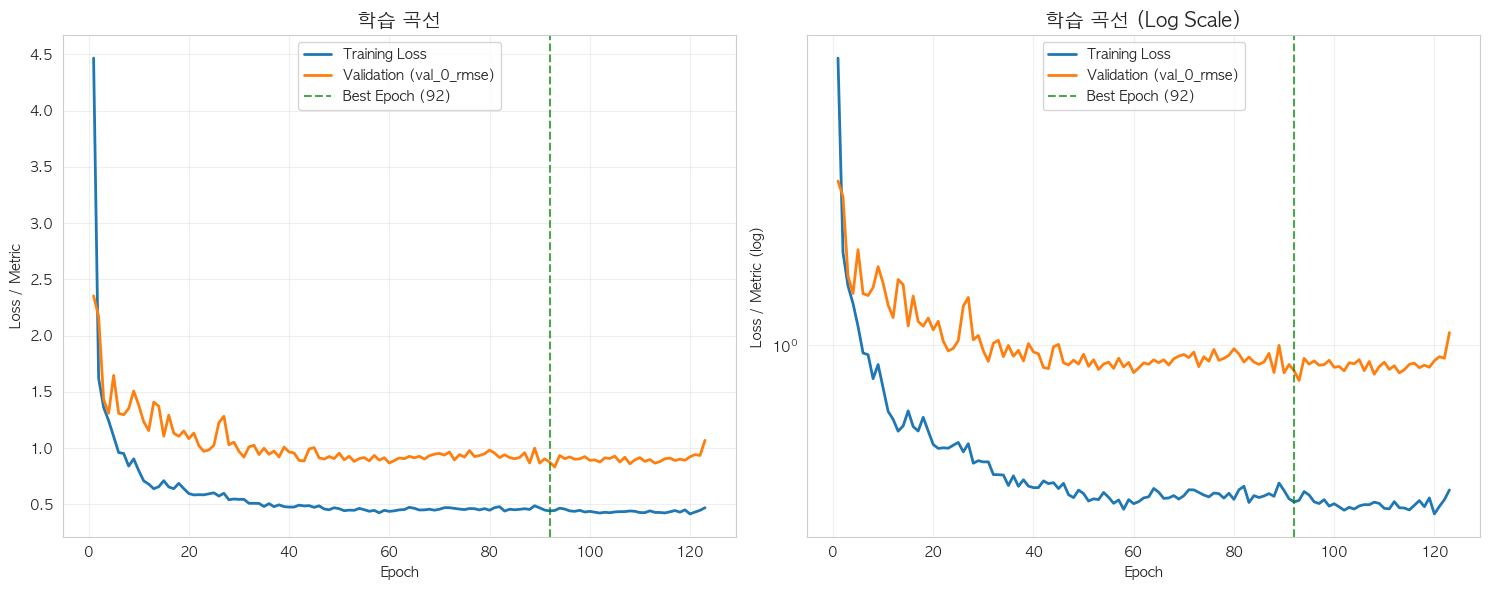

최종 Training Loss: 0.471046
최종 Validation (val_0_rmse): 1.069846
최소 Validation (val_0_rmse): 0.832978


In [22]:
# ================================================================
# Cell 10: 학습 곡선 분석 (robust for TabNet & Keras History)
# ================================================================
import matplotlib.pyplot as plt

def _to_history_dict(h):
    """
    History가 dict이든, Keras History 객체이든, 커스텀 객체이든
    가능한 한 dict로 변환해서 반환.
    변환 실패 시 빈 dict.
    """
    # 1) 이미 dict인 경우
    if isinstance(h, dict):
        return h

    # 2) Keras History: h.history 가 dict
    if hasattr(h, "history"):
        hh = getattr(h, "history")
        if isinstance(hh, dict):
            return hh

    # 3) dict(h) 가능한 케이스
    try:
        return dict(h)
    except Exception:
        pass

    # 4) vars(h) 시도 후 dict만 필터링
    try:
        v = vars(h)
        # Keras의 History는 {'epoch': [...], 'history': {...}} 구조이기도 함
        if isinstance(v, dict):
            if "history" in v and isinstance(v["history"], dict):
                return v["history"]
            return v
    except Exception:
        pass

    return {}

def _pick_first_key(d, candidates):
    """candidates 중 d에 존재하는 첫 번째 키를 반환. 없으면 None."""
    for k in candidates:
        if k in d:
            return k
    return None

if hasattr(tabnet, 'history') and tabnet.history is not None:
    raw_hist = tabnet.history
    history = _to_history_dict(raw_hist)

    if len(history) == 0:
        print("학습 히스토리를 찾지 못했습니다. 사용 가능한 속성을 출력합니다:")
        print(f"type(tabnet.history) = {type(raw_hist)}")
        print(f"dir(tabnet.history) = {dir(raw_hist)}")
    else:
        # 사용 가능 키 안내
        print(f"사용 가능한 history 키: {list(history.keys())}")

        # 손실/검증 지표 후보 키 (다양한 프레임워크/라이브러리 호환)
        loss_key_candidates = [
            "loss", "train_loss", "training_loss",
            "loss_epoch", "train_loss_epoch"
        ]
        val_key_candidates = [
            # Keras 스타일
            "val_loss", "val_mse", "val_rmse", 
            # pytorch_tabnet 일반 로그 패턴
            "val_0_rmse", "valid_0_rmse", "validation_0_rmse",
            "valid_rmse", "valid_loss", "val_score", "valid_score"
        ]

        loss_key = _pick_first_key(history, loss_key_candidates)
        val_key  = _pick_first_key(history, val_key_candidates)

        if loss_key is None and val_key is None:
            print("표준적인 'loss' / 'val_*' 키를 찾지 못했습니다. 사용 가능한 키를 확인해주세요.")
        else:
            # 에포크 축 길이 추정 (가장 긴 시계열 기준)
            series_list = []
            if loss_key is not None and isinstance(history[loss_key], (list, tuple)):
                series_list.append(len(history[loss_key]))
            if val_key is not None and isinstance(history[val_key], (list, tuple)):
                series_list.append(len(history[val_key]))

            if len(series_list) == 0:
                print("히스토리 값이 리스트 형태가 아닙니다. 원시 history를 확인하세요.")
            else:
                n_epochs = max(series_list)
                epochs = range(1, n_epochs + 1)

                print("\n학습 곡선 분석:")
                print(f"총 에포크(추정): {n_epochs}")
                if hasattr(tabnet, 'best_epoch'):
                    try:
                        print(f"베스트 에포크: {tabnet.best_epoch}")
                    except Exception:
                        pass

                # 플롯
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

                # 좌: 선형 축
                if loss_key is not None:
                    ax1.plot(range(1, len(history[loss_key]) + 1),
                             history[loss_key], label='Training Loss', linewidth=2)
                if val_key is not None:
                    ax1.plot(range(1, len(history[val_key]) + 1),
                             history[val_key], label=f'Validation ({val_key})', linewidth=2)

                ax1.set_title('학습 곡선', fontweight='bold', fontsize=14)
                ax1.set_xlabel('Epoch')
                ax1.set_ylabel('Loss / Metric')
                ax1.legend()
                ax1.grid(True, alpha=0.3)

                # 우: 로그 축
                if loss_key is not None:
                    ax2.semilogy(range(1, len(history[loss_key]) + 1),
                                 history[loss_key], label='Training Loss', linewidth=2)
                if val_key is not None:
                    ax2.semilogy(range(1, len(history[val_key]) + 1),
                                 history[val_key], label=f'Validation ({val_key})', linewidth=2)

                ax2.set_title('학습 곡선 (Log Scale)', fontweight='bold', fontsize=14)
                ax2.set_xlabel('Epoch')
                ax2.set_ylabel('Loss / Metric (log)')
                ax2.legend()
                ax2.grid(True, alpha=0.3)

                # 베스트 에포크 표시(가능한 경우)
                if hasattr(tabnet, 'best_epoch'):
                    try:
                        be = int(tabnet.best_epoch)
                        if be > 0:
                            ax1.axvline(x=be, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({be})')
                            ax2.axvline(x=be, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch ({be})')
                            ax1.legend(); ax2.legend()
                    except Exception:
                        pass

                plt.tight_layout()
                plt.show()

                # 학습 통계 출력
                def _last_val(arr):
                    try:
                        return float(arr[-1])
                    except Exception:
                        return None

                if loss_key is not None:
                    last_train = _last_val(history[loss_key])
                    if last_train is not None:
                        print(f"최종 Training Loss: {last_train:.6f}")
                if val_key is not None:
                    last_val = _last_val(history[val_key])
                    if last_val is not None:
                        print(f"최종 Validation ({val_key}): {last_val:.6f}")
                        try:
                            min_val = min(history[val_key])
                            print(f"최소 Validation ({val_key}): {min_val:.6f}")
                        except Exception:
                            pass
else:
    print("tabnet.history가 존재하지 않습니다. 학습이 완료되었는지 확인해주세요.")



상세 Feature Importance 분석
Top 15 중요 피처:
------------------------------
 1. 불쾌지수등급                   : 0.1254
 2. 강수량_7일_누적                : 0.1037
 3. 체감온도(°C)                 : 0.1012
 4. 최고습도(%)                  : 0.0681
 5. 폭우_여부                    : 0.0561
 6. 일_최저기온(°C)               : 0.0461
 7. 불쾌지수(DI)                 : 0.0459
 8. 일교차                      : 0.0427
 9. 습도표준편차                   : 0.0395
10. 일_최고기온(°C)               : 0.0352
11. 최저습도(%)                  : 0.0317
12. 공휴일                      : 0.0302
13. 생활인구                     : 0.0286
14. 세탁업                      : 0.0271
15. 수영장업                     : 0.0248

중요도 통계:
총 피처 수: 32
중요도 합계: 1.0000
상위 5개 피처 비중: 45.5%
상위 10개 피처 비중: 66.4%


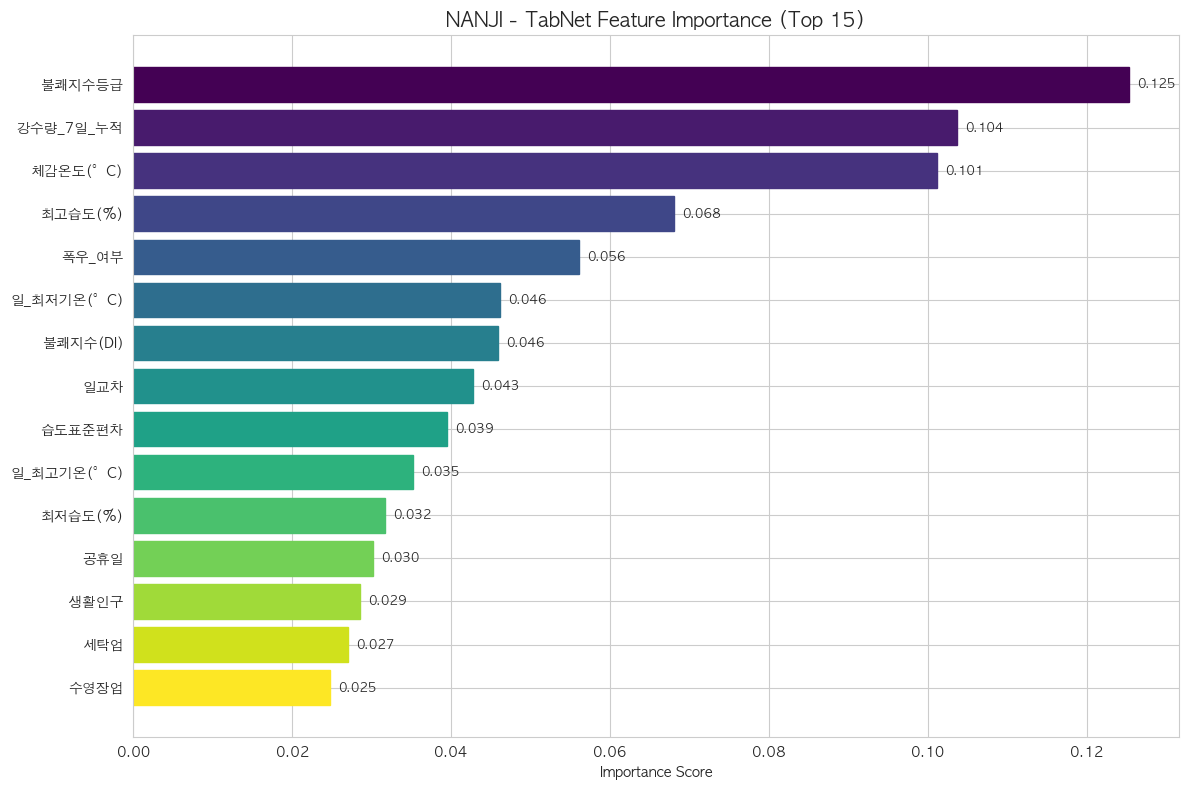

In [23]:
# ================================================================
# Cell 11: 상세 Feature Importance 분석
# ================================================================
if hasattr(tabnet, 'feature_importances_'):
    print(f"\n{'='*50}")
    print("상세 Feature Importance 분석")
    print("="*50)
    
    feature_importance = tabnet.feature_importances_
    feature_names = X_train.columns.tolist()
    
    # DataFrame으로 정리
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    
    print("Top 15 중요 피처:")
    print("-" * 30)
    for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
        print(f"{i:2d}. {row['Feature']:25s}: {row['Importance']:.4f}")
    
    # 중요도 통계
    print(f"\n중요도 통계:")
    print(f"총 피처 수: {len(feature_names)}")
    print(f"중요도 합계: {feature_importance.sum():.4f}")
    print(f"상위 5개 피처 비중: {importance_df.head(5)['Importance'].sum():.1%}")
    print(f"상위 10개 피처 비중: {importance_df.head(10)['Importance'].sum():.1%}")
    
    # 전체 Feature Importance 시각화
    plt.figure(figsize=(12, 8))
    
    # Top 15 피처만 표시
    top_features = importance_df.head(15)
    
    bars = plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'{center_name.upper()} - TabNet Feature Importance (Top 15)', 
              fontweight='bold', fontsize=14)
    plt.gca().invert_yaxis()
    
    # 색상 그라데이션 적용
    colors = plt.cm.viridis(np.linspace(0, 1, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # 값 표시
    for i, (bar, importance) in enumerate(zip(bars, top_features['Importance'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()



In [24]:
# ================================================================
# Cell 12: 최종 결과 요약 및 모델 저장
# ================================================================
print(f"\n{'='*60}")
print("최종 결과 요약")
print("="*60)

# 결과 요약
summary = {
    'center': center_name,
    'device_used': device,
    'training_time': training_time,
    'total_samples': len(X),
    'features': len(X.columns),
    'test_samples': len(y_test),
    **metrics
}

print(f"센터: {summary['center'].upper()}")
print(f"사용 디바이스: {summary['device_used']}")
print(f"학습 시간: {summary['training_time']:.1f}초")
print(f"총 샘플 수: {summary['total_samples']:,}")
print(f"피처 수: {summary['features']}")
print(f"테스트 샘플: {summary['test_samples']}")

print(f"\n최종 성능:")
print(f"R²:    {summary['R2']:.4f}")
print(f"RMSE:  {summary['RMSE']:.3f}")
print(f"MAE:   {summary['MAE']:.3f}")
print(f"MAPE:  {summary['MAPE']:.2f}%")
print(f"SMAPE: {summary['SMAPE']:.2f}%")

# 모델 저장 (선택사항)
save_model = True  # 모델을 저장하려면 True로 설정

if save_model:
    try:
        # 결과 디렉토리 생성
        import os
        os.makedirs('../results_tabnet_corrected', exist_ok=True)
        
        # 모델과 결과 저장
        model_data = {
            'model': tabnet,
            'metrics': metrics,
            'summary': summary,
            'x_scaler': x_scaler,
            'y_scaler': y_scaler,
            'feature_names': X_train.columns.tolist(),
            'predictions': {
                'y_true': y_true,
                'y_pred': y_pred
            }
        }
        
        model_filename = f"../results_tabnet_corrected/{center_name}_corrected_tabnet.pkl"
        with open(model_filename, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"\n✅ 모델 저장 완료: {model_filename}")
        
        # CSV로도 저장
        results_df = pd.DataFrame([summary])
        csv_filename = f"../results_tabnet_corrected/{center_name}_corrected_results.csv"
        results_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"✅ 결과 CSV 저장: {csv_filename}")
        
    except Exception as e:
        print(f"❌ 저장 중 오류 발생: {e}")

print(f"\n완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*60)


최종 결과 요약
센터: NANJI
사용 디바이스: mps
학습 시간: 1714.3초
총 샘플 수: 3,069
피처 수: 32
테스트 샘플: 307

최종 성능:
R²:    0.3945
RMSE:  73485.032
MAE:   42097.016
MAPE:  6.14%
SMAPE: 6.42%

✅ 모델 저장 완료: ../results_tabnet_corrected/nanji_corrected_tabnet.pkl
✅ 결과 CSV 저장: ../results_tabnet_corrected/nanji_corrected_results.csv

완료 시간: 2025-09-01 01:18:09
